In [1]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt
import urllib.request
from PIL import Image

In [2]:
MZ_MIN = 748
MZ_MAX = 766
SCAN_MIN = 1
SCAN_MAX = 920
PIXELS_X = 1000
PIXELS_Y = 1000

In [3]:
PIXELS_PER_MZ = PIXELS_X / (MZ_MAX - MZ_MIN)
PIXELS_PER_SCAN = PIXELS_Y / (SCAN_MAX - SCAN_MIN)

In [4]:
def tile_pixel_x_from_mz(mz):
    pixel_x = int((mz - MZ_MIN) * PIXELS_PER_MZ)
    return pixel_x

def tile_pixel_y_from_scan(scan):
    pixel_y = int((scan - SCAN_MIN) * PIXELS_PER_SCAN)
    return pixel_y

In [5]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/YHE211_1-mz-748-766-rt-2000-2200.pkl')
raw_df[(raw_df.frame_type == 0) & (raw_df.retention_time_secs >= 2054) & (raw_df.retention_time_secs <= 2055)].frame_id.unique()

array([18427, 18432])

In [6]:
raw_df = raw_df[(raw_df.frame_type == 0) & (raw_df.frame_id == 18427) & (raw_df.intensity > 50)]

In [7]:
raw_df['pixel_x'] = raw_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1)
raw_df['pixel_y'] = raw_df.apply(lambda row: tile_pixel_y_from_scan(row.scan), axis=1)

In [8]:
# sum the intensity of raw points that have been assigned to each pixel
pixel_intensity_df = raw_df.groupby(by=['pixel_x', 'pixel_y'], as_index=False).intensity.sum()


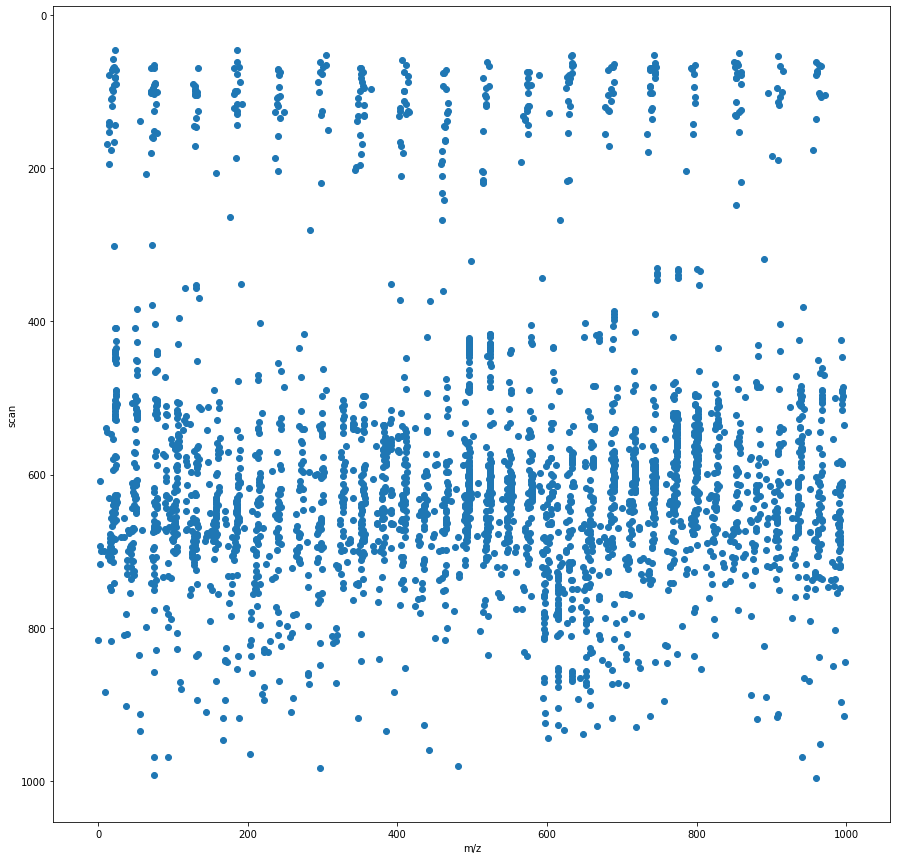

In [9]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(pixel_intensity_df.pixel_x, pixel_intensity_df.pixel_y)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

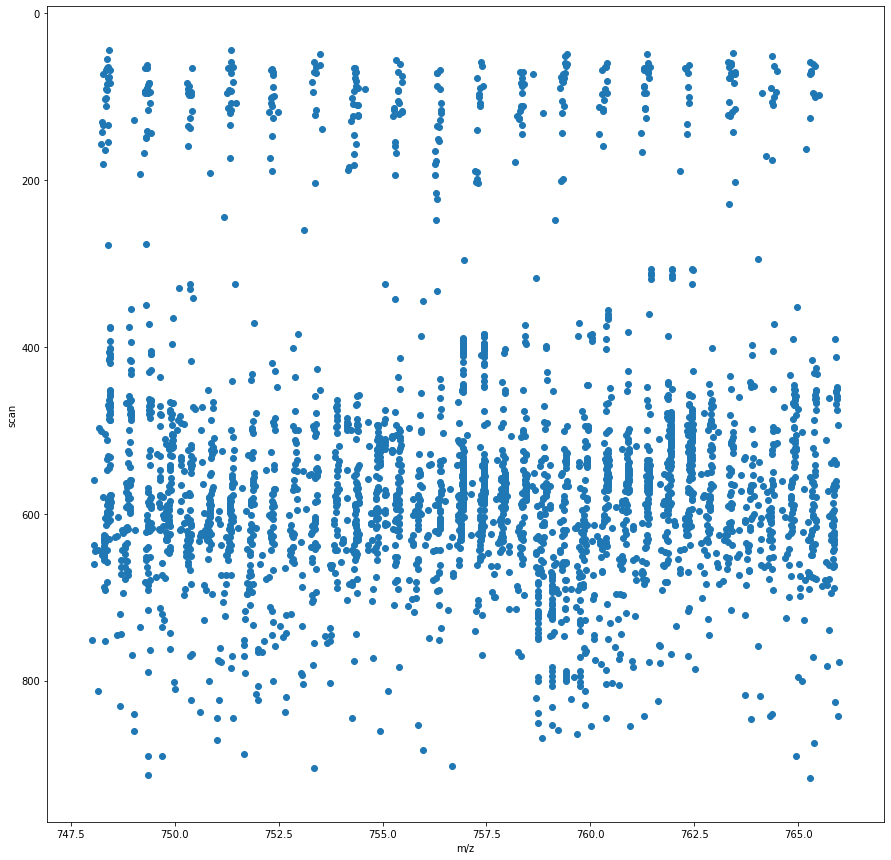

In [10]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### segment the raw data to reveal the isotopes in the feature

In [35]:
X = raw_df[['mz','scan']].values

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# raw_df['scan_scaled'] = raw_df.scan / 50.0
# X_scaled = raw_df[['mz','scan_scaled']].values

# cluster the data
dbscan = DBSCAN(eps=0.2, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)

In [37]:
raw_df['cluster'] = clusters

In [38]:
raw_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,cluster
518506,18427,0,751.802903,619,97,2054.261605,0
609754,18427,0,752.383524,99,83,2054.261605,1
2519716,18427,0,765.886466,826,91,2054.261605,-1
1113155,18427,0,755.940945,568,86,2054.261605,0
618646,18427,0,752.396430,591,62,2054.261605,0


In [39]:
import peakutils

In [40]:
colour_map = plt.get_cmap('Dark2')
norm = colors.Normalize(vmin=raw_df.cluster.min(), vmax=raw_df.cluster.max(), clip=False)

In [41]:
centroids_l = []
for group_name,group_df in raw_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        c = colour_map(norm(group_name), bytes=False)[:3]
        centroids_l.append((group_name, mz_centroid, scan_centroid, c))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz_centroid','scan_centroid','colour'])

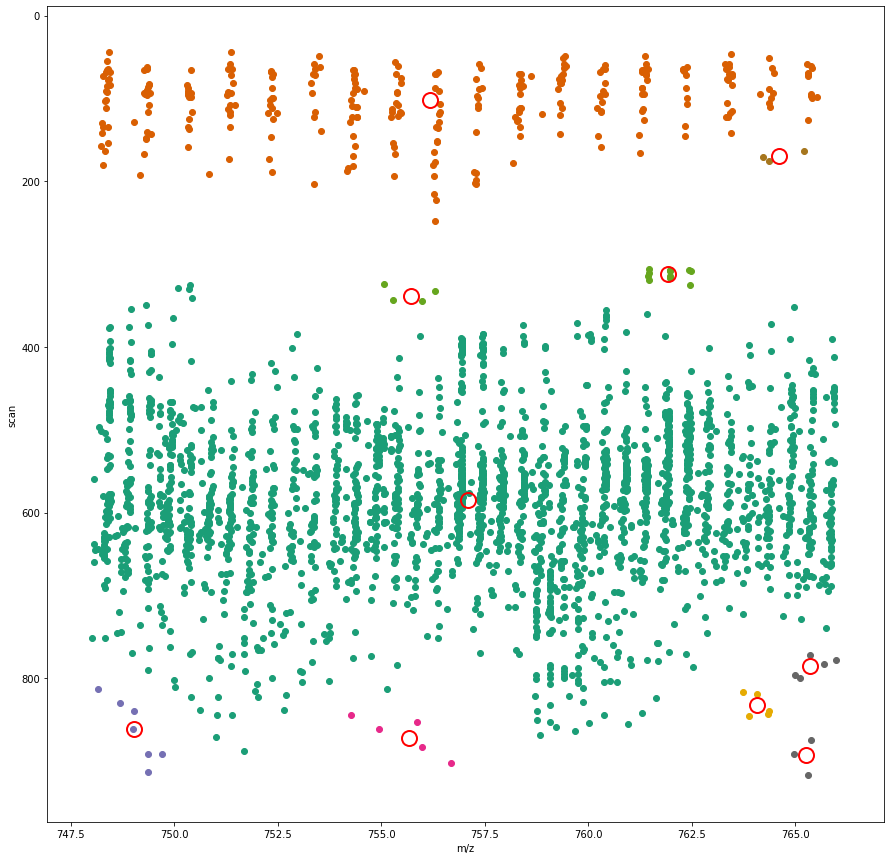

In [42]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

for idx,row in centroids_df.iterrows():
    cluster_df = raw_df[raw_df.cluster == row.cluster]
    plt.scatter(cluster_df.mz, cluster_df.scan, c=np.array([row.colour]))
    plt.plot(row.mz_centroid, row.scan_centroid, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='cluster centroid')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()